Problem: 
Implement variational Auto-encoders. Use the Frey Face dataset to train your network.
Sample points from the learned distribution by varying different latent variables to show that your
network has learned meaningful latent variables. Set the embedding vector size to 20.



In [30]:
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class FreyFaceDataset(Dataset):
    def __init__(self, path='frey_rawface.mat'):
        data = scipy.io.loadmat(path)['ff'].T  # shape (1965, 560)
        data = data / 255.0  # normalize to [0, 1]
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

# Initialize dataset
dataset = FreyFaceDataset('C:/Users/NAGHUL KRISHNA/Downloads/frey_rawface.mat')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [31]:
import torch
import torch.nn as nn


class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, data_type="binary"):
        super(VAE, self).__init__()
        # Encoder: layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)
        # Decoder: layers
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc41 = nn.Linear(hidden_size, input_size)
        self.fc42 = nn.Linear(hidden_size, input_size)
        # data_type: can be "binary" or "real"
        self.data_type = data_type

    def encode(self, x):
        h1 = torch.tanh(self.fc1(x))
        mean, log_var = self.fc21(h1), self.fc22(h1)
        return mean, log_var

    @staticmethod
    def reparameterize(mean, log_var):
        mu, sigma = mean, torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        return z

    def decode(self, z):
        h3 = torch.tanh(self.fc3(z))
        if self.data_type == "real":
            mean, log_var = torch.sigmoid(self.fc41(h3)), self.fc42(h3)
            return mean, log_var
        else:
            logits = self.fc41(h3)
            probs = torch.sigmoid(logits)
            return probs

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        return z_mean, z_logvar, self.decode(z)

In [32]:
from torch import optim

input_size = 560
hidden_size = 400
latent_size = 20

model = VAE(input_size, hidden_size, latent_size, data_type="binary").to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [33]:
import torch.nn.functional as F

def vae_loss(x, recon_x, mu, logvar, data_type="binary"):
    if data_type == "real":
        # Gaussian log-likelihood
        recon_mu, recon_logvar = recon_x
        recon_loss = 0.5 * torch.sum(recon_logvar + ((x - recon_mu) ** 2) / torch.exp(recon_logvar))
    else:
        # Binary cross-entropy
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train()

num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        mu, logvar, recon = model(batch)
        loss = vae_loss(batch, recon, mu, logvar, data_type="binary")
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataset):.4f}")


Epoch 1, Loss: 365.2930
Epoch 2, Loss: 355.0021
Epoch 3, Loss: 353.2042
Epoch 4, Loss: 351.7405
Epoch 5, Loss: 350.6653
Epoch 6, Loss: 350.0309
Epoch 7, Loss: 349.8319
Epoch 8, Loss: 349.5665
Epoch 9, Loss: 349.3863
Epoch 10, Loss: 349.4792
Epoch 11, Loss: 349.3816
Epoch 12, Loss: 349.3356
Epoch 13, Loss: 349.3528
Epoch 14, Loss: 349.4533
Epoch 15, Loss: 349.2492
Epoch 16, Loss: 349.2347
Epoch 17, Loss: 349.2547
Epoch 18, Loss: 349.1855
Epoch 19, Loss: 349.1353
Epoch 20, Loss: 349.1917
Epoch 21, Loss: 349.2043
Epoch 22, Loss: 349.1613
Epoch 23, Loss: 349.1873
Epoch 24, Loss: 349.1072
Epoch 25, Loss: 349.1644
Epoch 26, Loss: 349.0901
Epoch 27, Loss: 349.0255
Epoch 28, Loss: 349.1328
Epoch 29, Loss: 349.0359
Epoch 30, Loss: 349.0223


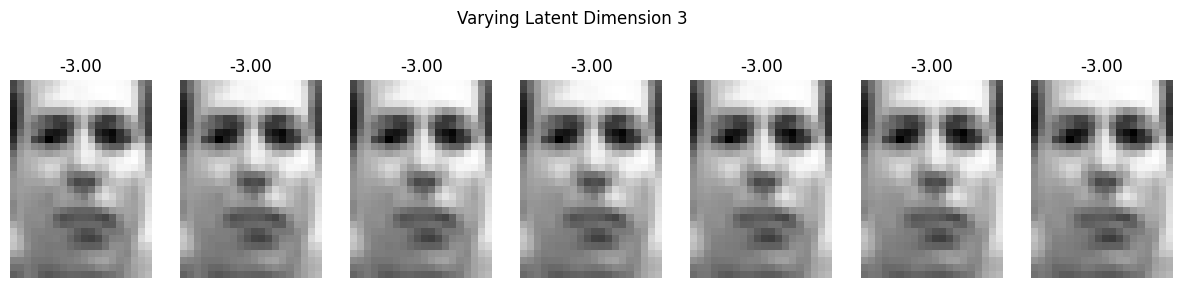

In [35]:
import matplotlib.pyplot as plt

def plot_latent_variation(model, dim_idx, z_range=(-3, 3), steps=7):
    model.eval()
    z = torch.zeros((steps, latent_size)).to(device)
    z[:, dim_idx] = torch.linspace(z_range[0], z_range[1], steps)
    
    with torch.no_grad():
        recon = model.decode(z).cpu().numpy()

    fig, axes = plt.subplots(1, steps, figsize=(15, 3.5))
    for i, img in enumerate(recon):
        axes[i].imshow(img.reshape(28, 20), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{z[0, dim_idx]:.2f}")
    plt.suptitle(f"Varying Latent Dimension {dim_idx}")
    plt.show()

# Example usage
plot_latent_variation(model, dim_idx=3)


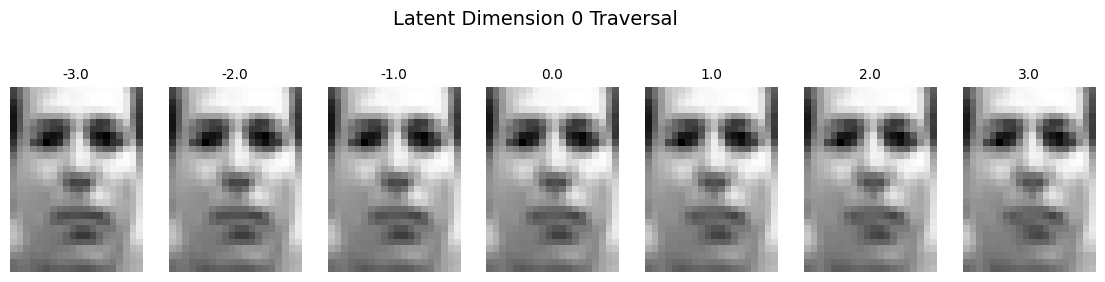

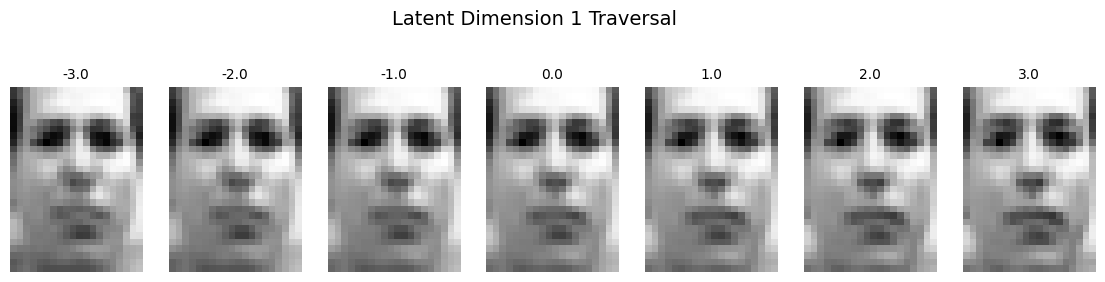

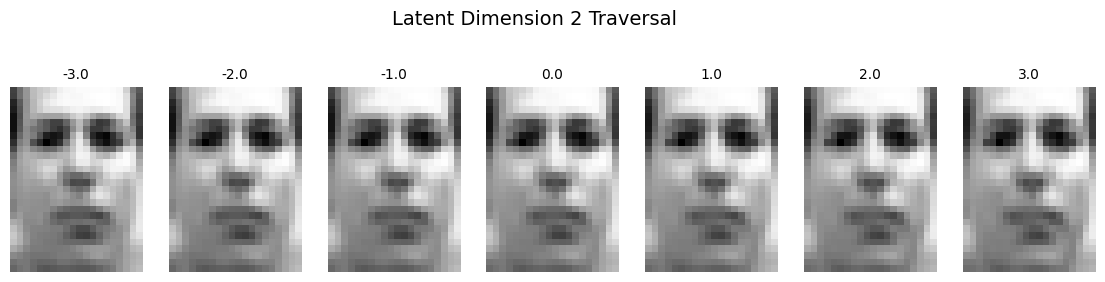

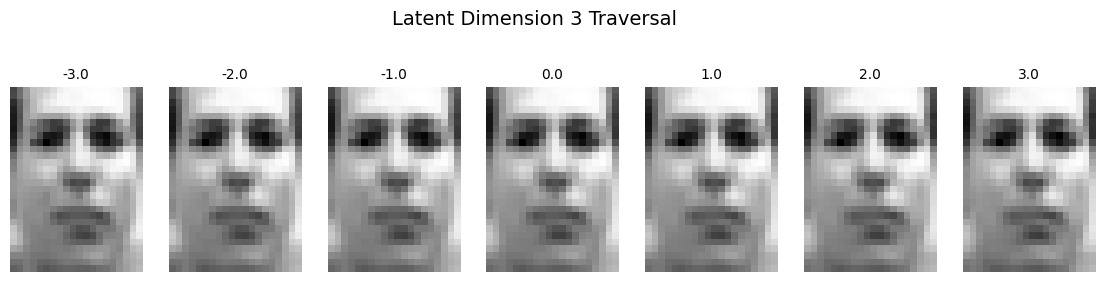

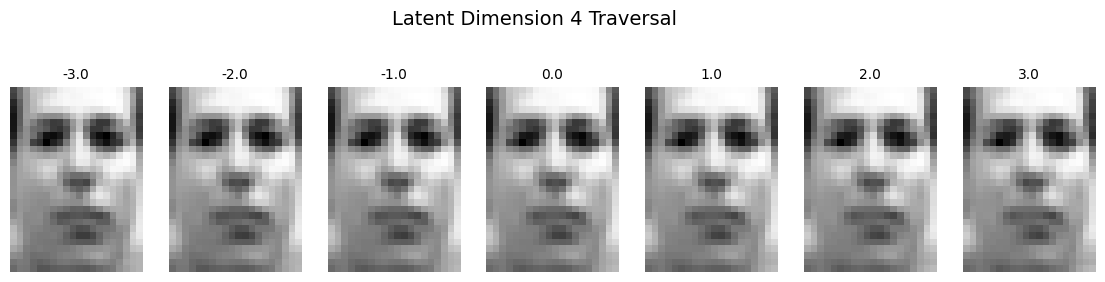

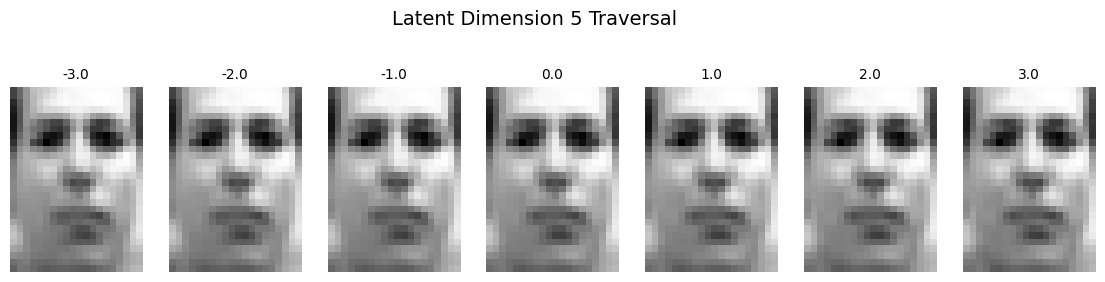

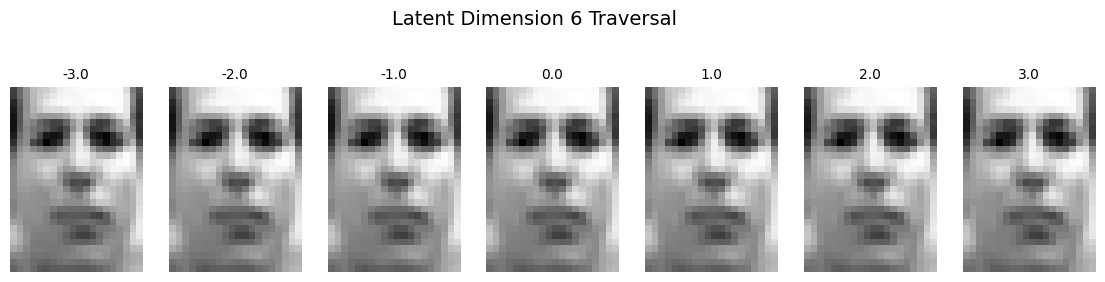

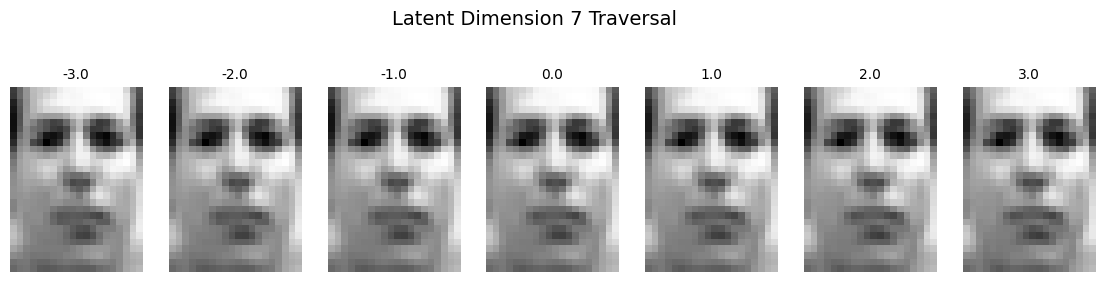

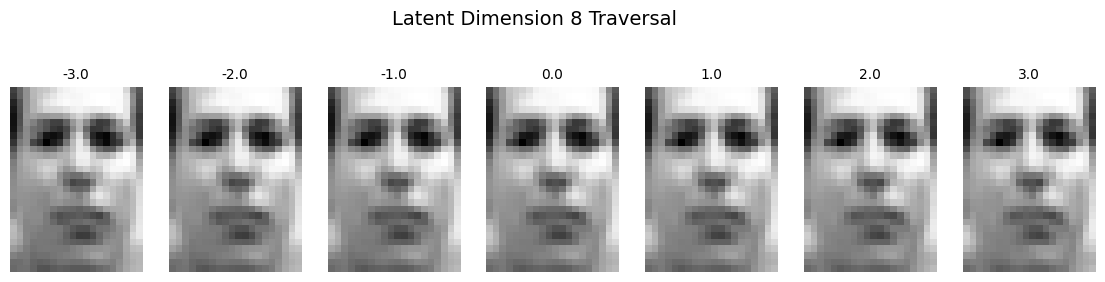

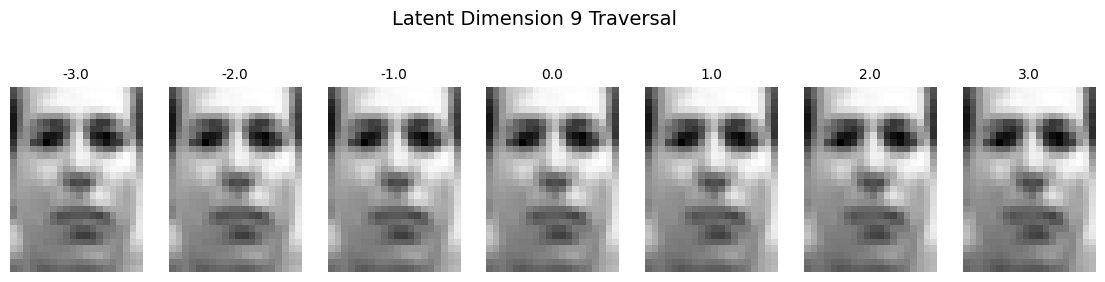

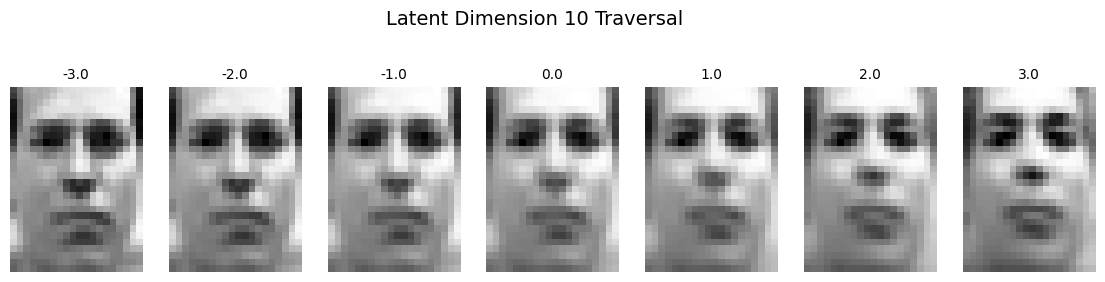

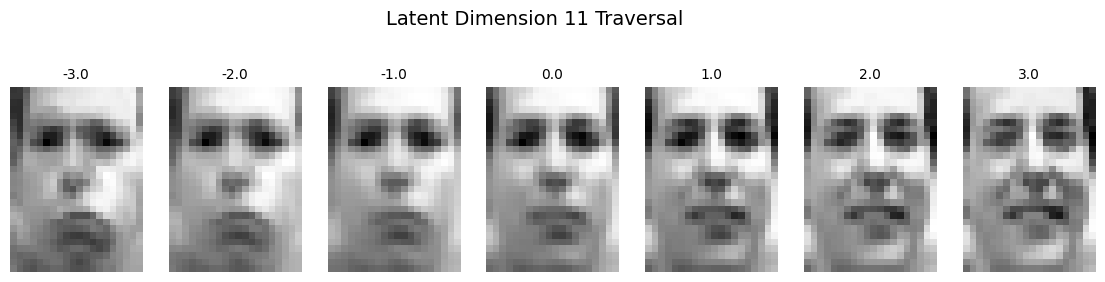

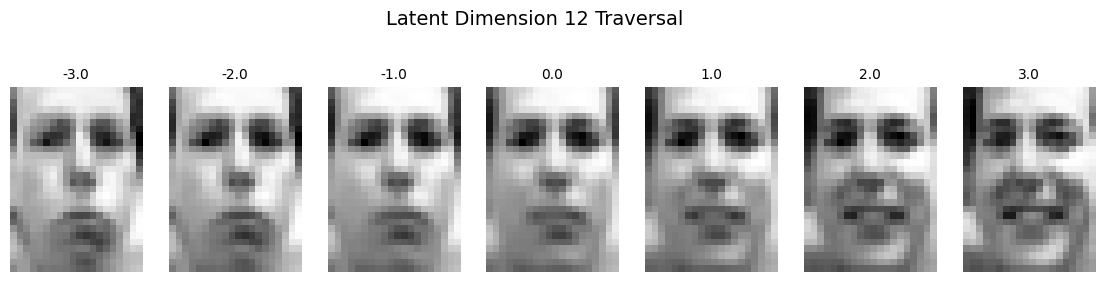

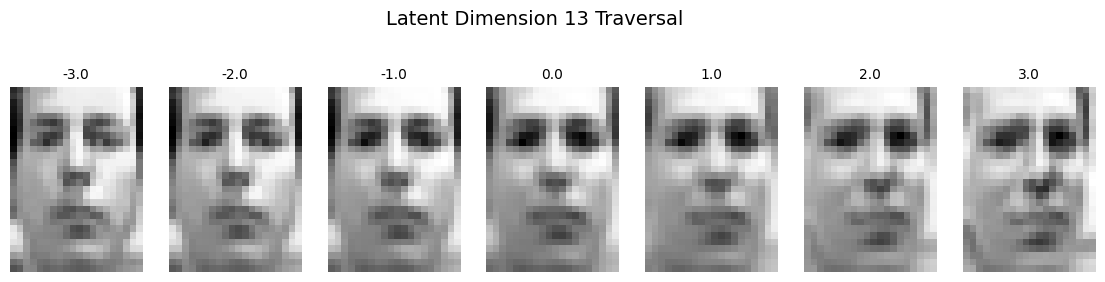

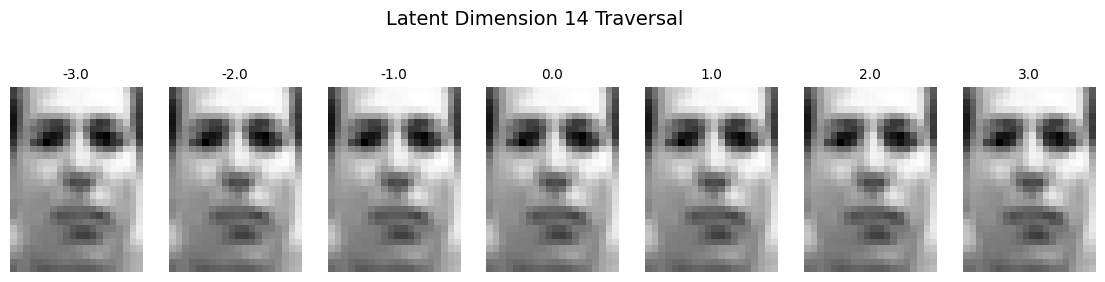

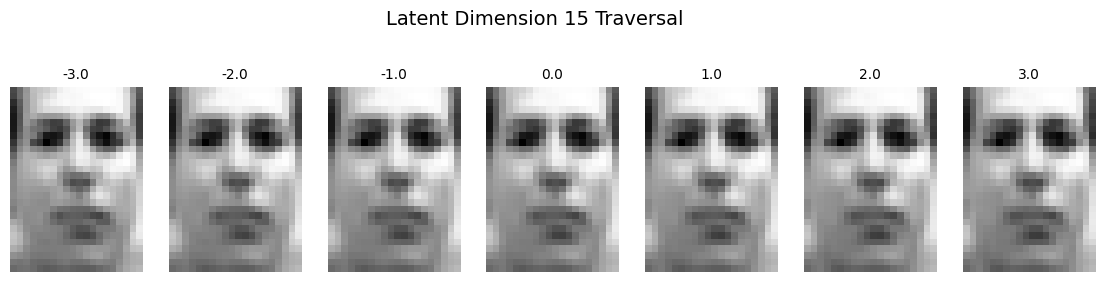

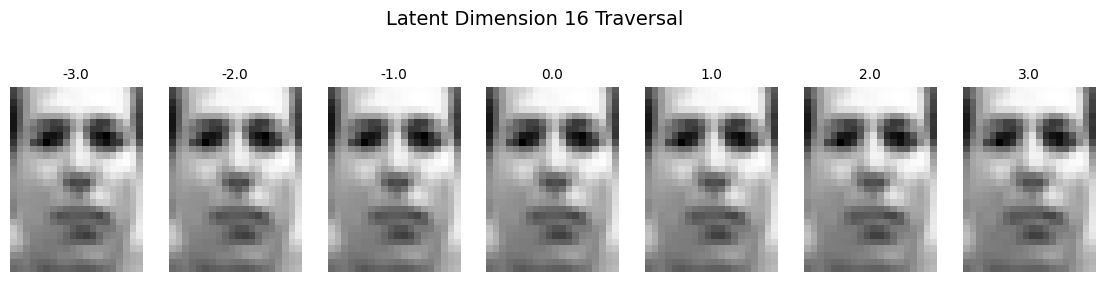

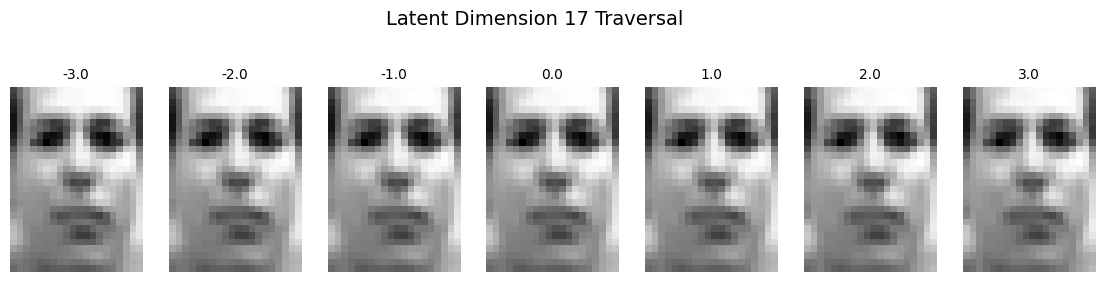

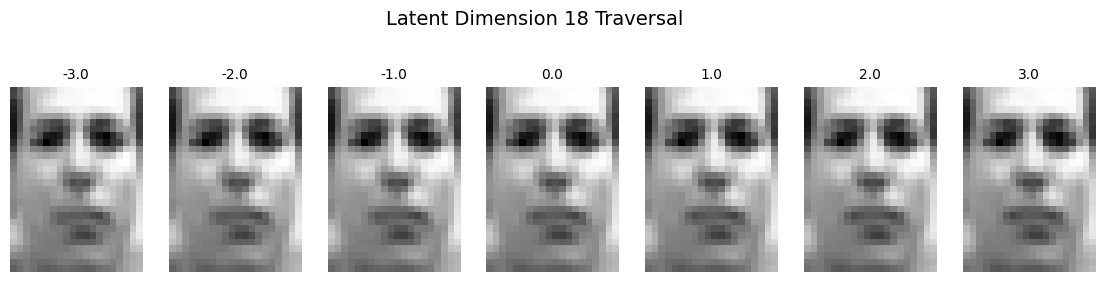

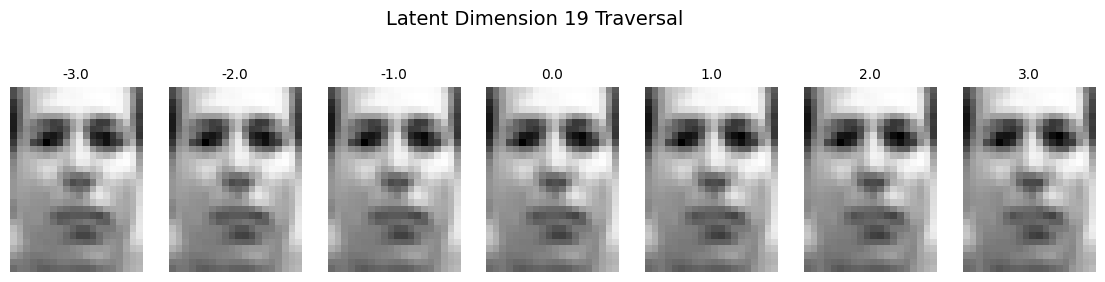

In [38]:
import matplotlib.pyplot as plt
import torch

def plot_latent_traversal(model, latent_size=20, steps=7, range_val=3.0):
    model.eval()
    device = next(model.parameters()).device

    # Create evenly spaced values in the latent range
    variation_vals = torch.linspace(-range_val, range_val, steps)

    for dim in range(latent_size):
        z_samples = []
        for val in variation_vals:
            z = torch.zeros((1, latent_size)).to(device)
            z[0, dim] = val  # vary only one latent dimension
            z_samples.append(z)

        z_tensor = torch.cat(z_samples, dim=0)

        with torch.no_grad():
            decoded = model.decode(z_tensor).cpu().numpy()

        # Plot results
        fig, axes = plt.subplots(1, steps, figsize=(steps * 2, 3.5))
        for i, ax in enumerate(axes):
            ax.imshow(decoded[i].reshape(28, 20), cmap='gray')
            ax.axis('off')
            ax.set_title(f'{variation_vals[i]:.1f}', fontsize=10)
        plt.suptitle(f'Latent Dimension {dim} Traversal', fontsize=14)
        plt.show()

plot_latent_traversal(model, latent_size=20)